# Checking SWOT Passing Times
This notebook is used to verify the accuracy of predicted SWOT passing times by comparing them with previously downloaded observed data. The analysis includes calculating time differences and visualizing the results.

In [ ]:
# Import necessary libraries
import os
import geopandas as gpd
import pandas as pd
from datetime import timedelta, datetime
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tools import process_orbit_data

## Load and Process Data
Here, we load the predicted and observed SWOT passing data. The observed data is extracted from files, and both datasets are filtered and aligned for comparison.

In [ ]:
# Process predicted and observed data
predicted = process_orbit_data()
data = []
for fname in glob("/mnt/bigcreek_nfs_share/swot/v2_0_1/Unsmoothed/*/*"):
    cycle, npass, time0, time1 = fname.split("/")[-1].split("_")[-5:-1]
    cycle, npass = int(cycle), int(npass)
    time0, time1 = [datetime.strptime(timei, "%Y%m%dT%H%M%S") for timei in [time0, time1]]
    orbit = fname.split("/")[-2]
    data.append([cycle, npass, time0, time1, orbit])

observed = pd.DataFrame(data, columns=["CYCLE","PASS","start_time","end_time", "ORBIT"]).sort_values("start_time")
overlap = (predicted["TIME"]>=observed["start_time"].min()-timedelta(days=1))&(predicted["TIME"]<=observed["end_time"].max()+timedelta(days=1))
predicted = predicted[overlap].reset_index(drop=True)

predicted = predicted.set_index(["CYCLE", "PASS"])
observed = observed.set_index(["CYCLE", "PASS"])

/home/iury/miniforge3/envs/coringa3.0.0/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: data/external/swot_swath/swot_calval_orbit_june2015-v2_swath.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


## Calculate Time Differences
The time differences between predicted and observed passing times are calculated in seconds. This will help in assessing the accuracy of the predictions.

In [ ]:
# Calculate time differences
predicted_time = predicted["TIME"]
observed_time = observed.start_time
time_difference = (predicted_time-observed_time).dt.total_seconds()

## Quantile Analysis of Time Differences
The quantiles of the time differences (in minutes) are computed to summarize the range of deviations.

In [ ]:
# Compute quantiles of time differences
(time_difference/60).dropna().quantile([0,1])

0.0   -39.678800
1.0     0.687867
dtype: float64

## Visualize Time Differences
A histogram of the time differences (in minutes) is plotted to visualize the distribution of deviations. The y-axis is logarithmic to better display the range of values.

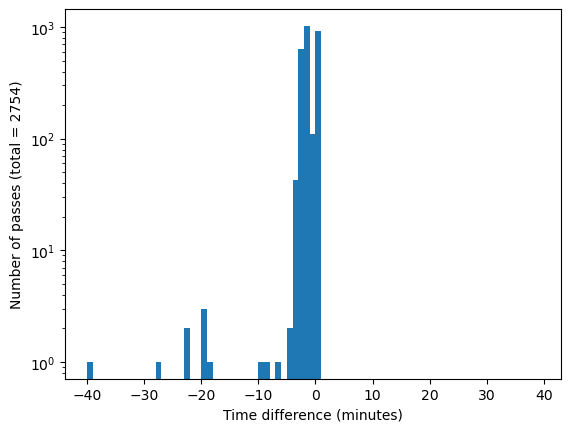

In [84]:
# Plot histogram of time differences
fig, ax = plt.subplots()
(time_difference/60).dropna().plot.hist(bins=np.arange(-40,40,1), log=True)
ax.set(ylabel=f"Number of passes (total = {(time_difference/60).dropna().shape[0]})", xlabel="Time difference (minutes)");